# Training the HATPredict Model

This notebook trains, introspects, and saves a model to predict the **free energy barrier (∆G‡)** of **hydrogen atom transfer (HAT)** reactions using input features from **density functional theory (DFT)**.

The model can be used for any HAT reaction of the form:

**A–H  +  B·  ⇌  A·  +  B–H**

but for the purposes of training the model it is easier to think in terms of the most common reaction of this type, in which a substrate (**Sub–H**) undergoes hydrogen abstraction by a catalyst (**Cat·**):

**Sub–H  +  Cat·  ⇌  Sub·  +  Cat–H**

because the training and test sets involve known HAT catalysts whose free energy barriers and input features are computed with a wide variety of substrates.

## 1. Imports and Optional Google Colab Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8.0, 8.0)

import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('poster')

import xgboost

from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import shap

from get_barriers import add_reverse_reactions, split_and_tweak, test_with_reverse_reactions

In [3]:
GOOGLE_DRIVE_PATH = ''

# Uncomment the section below if running on Google Colab
"""
from google.colab import drive

drive.mount('/content/drive')

# Relative path to this notebook on Google Drive
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'HAT'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
"""
pass

## 2.  Import Training and Test Data

We consider reactions in which a substrate (**Sub–H**) undergoes hydrogen abstraction by a catalyst (**Cat·**):

**Sub–H  +  Cat·  ⇌  Sub·  +  Cat–H**

This notebook trains and saves a model to predict the **free energy barrier (∆G‡)** of these reactions.

We begin by importing the training data (`data_train`) and test data (`data_hong`) adapted from Professor Xin Hong's hydrogen atom transfer (HAT) machine learning [paper](https://doi.org/10.1039/D1QO01325D).  Note that this training data contains only 17 different HAT catalysts, and that all of the catalysts in the test data are also found in the training data; only the substrates are unseen.

Thus, we also import an additional test data set (`data_houk`) adapted from Professor Kendall N. Houk's [paper](https://doi.org/10.1021/jacs.2c00389).  Although small, this test data contains three catalysts that are _not_ present in the training data, and can thus help us to build a better HAT machine learning model that generalizes not only to new substrates but also to new catalysts.

The descriptors for each of these datasets were extracted by processing density functional theory (DFT) Gaussian computations using the `get_descriptors.py` script.

Note that we **double the size of the data** by automatically including all of the reverse reactions:

**Cat–H  +  Sub·  ⇌  Cat·  +  Sub–H**

This improves model performance on new and unseen catalysts without requiring any new data collection.

In [4]:
data_train = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, 'training_data/descriptors.csv'))
data_hong = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, 'test_data/hong_molecules/descriptors.csv'))
data_houk = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, 'test_data/houk_molecules/descriptors.csv'))

x_train, y_train, rxns_train, group_train = split_and_tweak(add_reverse_reactions(data_train))
x_houk, y_houk, rxns_houk, group_houk = split_and_tweak(add_reverse_reactions(data_houk))
x_hong, y_hong, rxns_hong, group_hong = split_and_tweak(add_reverse_reactions(data_hong))

## 3.  Train an XGBoost Model with Hyperopt

In this section, we train an [XGBoost](https://xgboost.readthedocs.io/en/stable/index.html) model on the training data.  The hyperparameter search is performed via grouped 5-fold cross validation with Bayesian optimization ([Hyperopt](http://hyperopt.github.io/hyperopt/)).

Reactions are assigned to cross-validation groups based on the identity of their substrate (forward and reverse reactions are always assigned to the same group).  Because substrate and catalyst descriptors exchange positions in the forward and reverse reactions (see reactions above), and because every cross-validation fold contains unique substrates, this ensures that for every input descriptor, many values in the validation set are not present in the corresponding training set.

The loss to be minimized is the average, over all 5 validation sets, of the root mean square error (RMSE) of the predicted free energy barriers (∆G‡) in units of kcal/mol.

The cell below defines and prepares the training process.

In [5]:
# Construct DMatrix to use xgboost
xgb_train = xgboost.DMatrix(x_train.values, label=y_train.values)

# Split training data based on groups for 5-fold cross-validation
gkf = list(GroupKFold(n_splits=5).split(x_train, y_train, group_train))

# Define the hyperparameter space to be searched with Hyperopt
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': hp.quniform('max_depth', 1, 12, 1),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'reg_alpha': hp.loguniform('alpha', -10, 10),
    'num_boost_round': hp.quniform('num_boost_round', 1, 1000, 1),
}

def hyperparameter_tuning_cv(space):
    """
    Hyperparameter tuning function to be optimized via cross-validation.

    Arguments:

        - space: a dictionary whose keys are hyperparameters to be searched,
                 and whose values are distributions to search over

    Returns:

        - a dictionary with the following keys:

            - 'loss': the loss function to be minimized over the hyperparameter
                      space

            - 'loss_variance': optionally an estimate of the variance of this
                               loss function

            - 'status': STATUS_OK indicating the loss was properly computed for
                        a set of hyperparameters
    """

    # Define hyperparameters for xgboost.cv, with reference to the space of
    # hyperparameters being searched over
    param_grid = {
        'max_depth': int(space['max_depth']),
        'gamma': space['gamma'],
        'reg_alpha': space['reg_alpha'],
        'min_child_weight': space['min_child_weight'],
        'subsample': space['subsample'],
        'learning_rate': space['learning_rate'],
        'colsample_bytree': space['colsample_bytree'],
        'eval_metric': 'rmse',
        'seed': 42,
        'nthread': -1
    }

    # Perform cross-validation for the set of hyperparameters in param_grid
    xgb_cv = xgboost.cv(param_grid,
                        xgb_train,
                        num_boost_round=int(space['num_boost_round']),
                        folds=gkf)

    # Extract the loss and an estimate of the variance of the loss from
    # cross-validation
    rmse_mean = xgb_cv['test-rmse-mean'].iloc[-1]
    rmse_var = (xgb_cv['test-rmse-std'].iloc[-1])**2

    return {'loss': rmse_mean, 'loss_variance': rmse_var, 'status': STATUS_OK}

The cell below actually carries out model training with Bayesian optimization using XGBoost with cross-validation, and prints out the best hyperparameters that minimize the loss.  It may take several hours to run.

In [6]:
# Define a Trials object to store the results of the hyperparameter search
trials_cv = Trials()

# Use Hyperopt to optimize the hyperparameters
best_params_hyperopt = fmin(
    fn=hyperparameter_tuning_cv,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials_cv,
    rstate=np.random.default_rng(23),
    #timeout=60*30                       # Timeout after 30 minutes, comment out when not testing
)

# Print a dictionary of the best hyperparameters
print(best_params_hyperopt)

100%|██████████| 100/100 [55:46<00:00, 33.46s/trial, best loss: 1.087544618583285]  
{'alpha': 5.149827732893656e-05, 'colsample_bytree': 0.7640414077638942, 'gamma': 0.0013879909179442785, 'learning_rate': 0.021428911817465653, 'max_depth': 10.0, 'min_child_weight': 8.312497834953593, 'num_boost_round': 951.0, 'subsample': 0.5909178839362138}


We collect the best parameters obtained with Hyperopt (as well as a few options that were not searched) and retrain the model on the entire training data set.

In [7]:
# Best hyperparameters found with Hyperopt
best_params = {
    'alpha': 5.149827732893656e-05,
    'colsample_bytree': 0.7640414077638942,
    'gamma': 0.0013879909179442785,
    'learning_rate': 0.021428911817465653,
    'max_depth': 10,
    'min_child_weight': 8.312497834953593,
    'subsample': 0.5909178839362138,
    'eval_metric': 'rmse',
    'seed': 42,
    'nthread': -1
}

xgb = xgboost.train(best_params, xgb_train, num_boost_round=951)

## 4.  Model Results

In this section, we investigate the results of the Bayesian-optimized XGBoost model.  In particular, we analyze the performance of the model on the training set (`data_train`) and both test sets (`data_hong` and `data_houk`).

Below is a helper functions for plotting model results.

In [8]:
def plot_results(y_true, y_pred, min_lim=7, max_lim=29,
                 hue=None, hue_labels=None):
    """
    Function which plots ML-predicted barriers (y-axis) vs. ground-truth
    DFT-computed barriers (x-axis).

    Arguments:

        - y_true: Pandas series whose entries correspond to the ground-truth
                  DFT-computed free energy barriers for hydrogen atom transfer
                  reactions

        - y_pred: Pandas series whose entries correspond to the ML-predicted
                  free energy barriers for hydrogen atom transfer reactions

        - min_lim: Int or float with the minimum limit for the x-axis and
                   y-axis (in kcal/mol)

        - max_lim: Int or float with the maximum limit for the x-axis and
                   y-axis (in kcal/mol)

        - hue: An optional Pandas series whose entries contain labels according
               to which points are to be colored

        - hue_labels: An optional list of labels corresponding to the different
                      hues (need to experiment to get this list in the correct
                      order)

    Returns:

        Nothing
    """

    fig, ax = plt.subplots()

    # Scatterplot of ML-computed barriers (y-axis) vs.
    # ground-truth DFT-computed barriers (x-axis)
    sns.scatterplot(x=y_true, y=y_pred, hue=hue, ax=ax)
    ax.set_xlabel('DFT-Computed Barrier (kcal/mol)')
    ax.set_ylabel('ML-Computed Barrier (kcal/mol)')
    ax.set_xticks(range(2*(min_lim // 2), 2*(max_lim//2 + 1), 2))
    ax.set_yticks(range(2*(min_lim // 2), 2*(max_lim//2 + 1), 2))
    ax.set_xlim(min_lim, max_lim)
    ax.set_ylim(min_lim, max_lim)

    # If hue labels are provided, put them on the legend to identify the
    # meaning of the color of each point
    if hue_labels is not None:
        ax.legend(loc='lower right', labels=['_nolegend_'] + hue_labels)
    # Otherwise remove the legend
    else:
        ax.legend([], [], frameon=False)

    # Add a black dashed y = x line; for a good model points should fall
    # near this line
    x = np.linspace(min_lim, max_lim, 100)
    ax.plot(x, x, color='black', ls='--')

    # Add yellow bands extending 1.4 kcal/mol above and below the y = x line;
    # points within this region correspond to reaction rates predicted
    # correctly to within a factor of 10
    bandwidth = 1.4
    ax.fill_between(x, x+bandwidth, x-bandwidth, alpha=0.2, color='yellow')

    # Compute accuracy statistics
    R2 = r2_score(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    # Display accuracy statistics on graph
    ax.text(0.02, 0.98,
            'R$^2$ = %.2f\nMAE = %.2f kcal/mol\nRMSE = %.2f kcal/mol' % (R2, MAE, RMSE),
            verticalalignment='top', transform=ax.transAxes)

For Xin Hong's original training data (`data_train`), we plot the predicted free energy barriers from the model versus the ground-truth free energy barriers from density functional theory (DFT) transition state computations.

In this plot, and all others that follow, the highlighted yellow area corresponds to free energy barrier predictions that are correct to within 1.4 kcal/mol.  This corresponds to estimating a reaction rate constant correctly to within a factor of 10 at room temperature, which is the most common benchmark used in quantum chemistry to determine the accuracy of a computational method.

However, the near-perfect fit suggests that this model might be overfitting the training data.

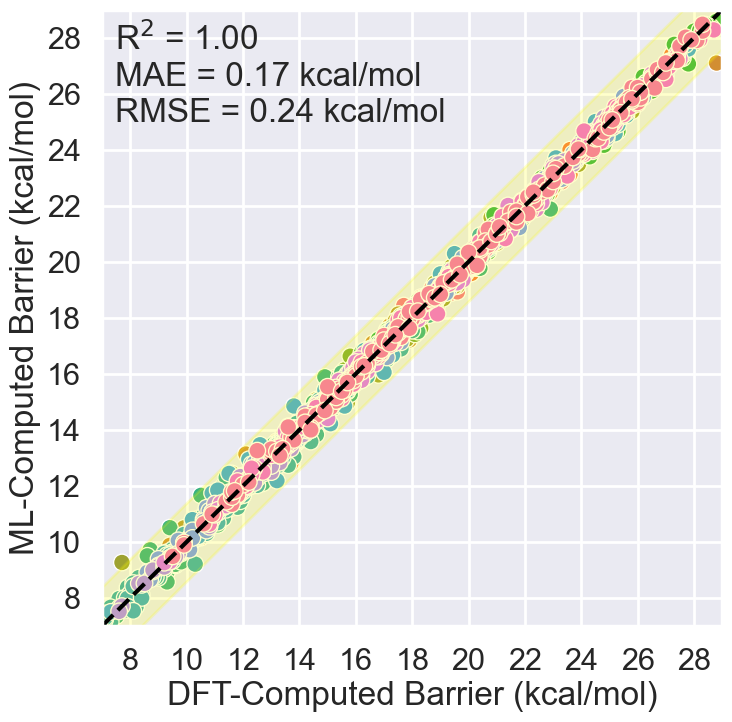

In [9]:
# Xin Hong Training Set
n_train, y_train_pred = test_with_reverse_reactions(x_train, xgb)
plot_results(y_train[:n_train], y_train_pred[:n_train],
             hue=rxns_train['cat_file'][:n_train])

We now plot the results of the model on our two test sets.  First, we plot the results for Xin Hong's original test data (`data_hong`).  Recall that every catalyst in Xin Hong's test data is also present in the training data; only the substrates are unseen.

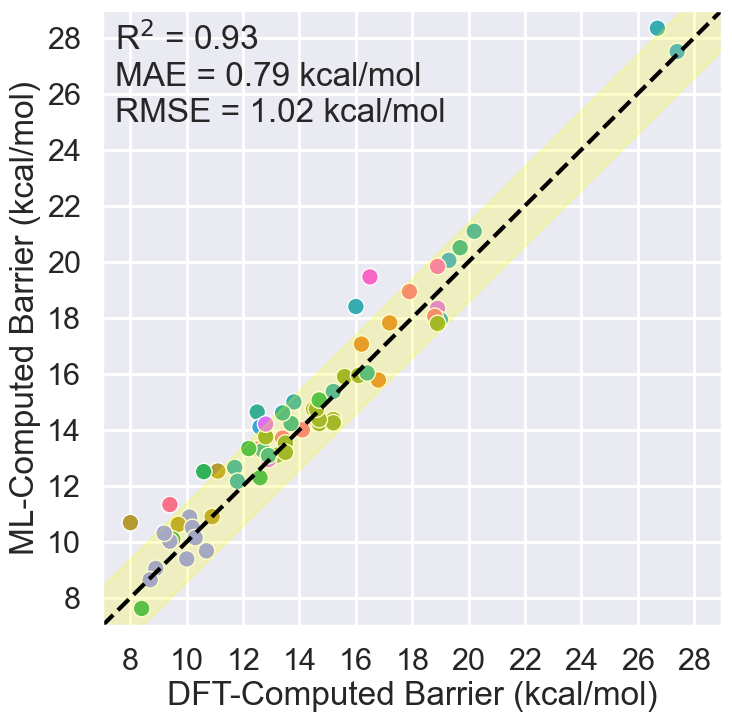

In [10]:
# Xin Hong Test Set
n_hong, y_hong_pred = test_with_reverse_reactions(x_hong, xgb)
plot_results(y_hong[:n_hong], y_hong_pred[:n_hong],
             hue=rxns_hong['cat_file'][:n_hong])

Second, we plot the results for test data adapted from Kendall N. Houk (`data_houk`).  Note that this data set, while small, contains three (out of four) catalysts that are not present in the training data (the t-BuO· catalyst is present in the training data).

The handle <matplotlib.collections.PathCollection object at 0x7f949276d550> has a label of '_nolegend_' which cannot be automatically added to the legend.


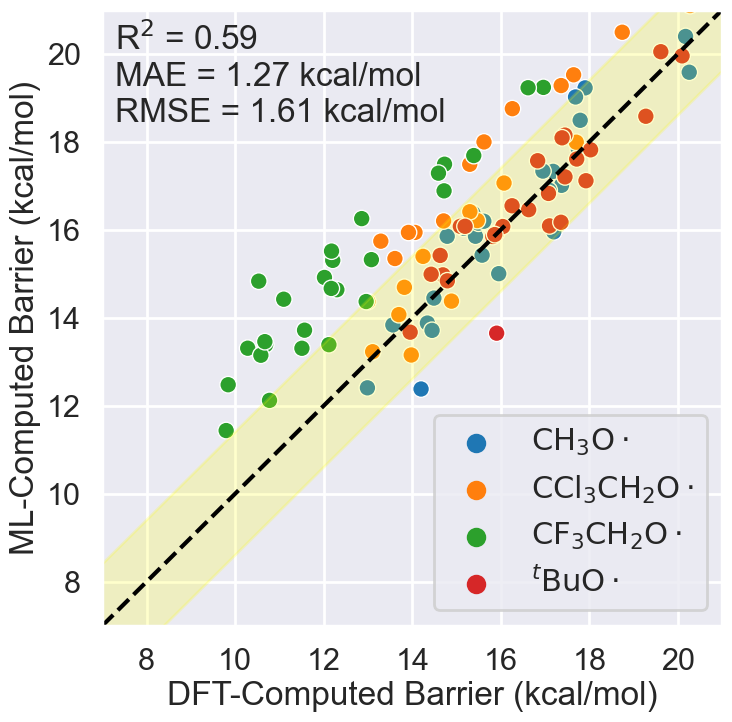

In [11]:
# Houk Test Set
labels_houk = [r'$\mathrm{CH}_3\mathrm{O}\cdot$',
               r'$\mathrm{CCl}_3\mathrm{CH}_2\mathrm{O}\cdot$',
               r'$\mathrm{CF}_3\mathrm{CH}_2\mathrm{O}\cdot$',
               r'$^t\mathrm{BuO}\cdot$']
n_houk, y_houk_pred = test_with_reverse_reactions(x_houk, xgb)
plot_results(y_houk[:n_houk], y_houk_pred[:n_houk], max_lim=21,
             hue=rxns_houk['cat_file'][:n_houk], hue_labels=labels_houk)

We observe that the model performs much better on Xin Hong's test data (`data_hong`) than on Kendall N. Houk's test data (`data_houk`).  Since `data_houk` contains unseen catalysts, but `data_hong` does not, we hypothesize that the model is still overfitting to the catalysts that are present in the training data.

## 5. Reduce Overfitting to Catalysts Present in the Training Data

The best long-term solution to this overfitting problem is to collect additional data so that all catalysts present in the validation (and test) sets are completely absent from the training sets.  I am currently working to collect this data.

In the meanwhile, to reduce model overfitting, we consider the dependence of our XGBoost model on the number of estimators (the total number of decision trees considered in the boosting algorithm).  This is the `num_boost_round` parameter.

Below, we define a function to plot the loss (average cross-validation root mean square error in ∆G‡) versus `num_boost_round`.

In [12]:
def scan_n_trees(params, low=10, high=250, interval=10):
    """
    For a given XGBoost model with a defined set of hyperparameters, this
    function scans the number of decision trees in the model (num_boost_round)
    and plots the loss versus the number of decision trees.
    The values of num_boost_round to be scanned are given by
    range(low, high + interval, interval).

    Arguments:

        - params: a dictionary whose keys are hyperparameter names and whose
                  values are hyperparameter values, for use with xgboost.cv

        - low: an integer corresponding to the lowest value of
               num_boost_round to scan

        - high: an integer corresponding to the highest value of
                num_boost_round to scan

        - interval: an integer corresponding to the difference in the number
                    of decision trees between adjacent points in the scan

    Returns:

        Nothing
    """

    # Array for tracking average cross-validation root mean square error
    rmse_means = []

    for i in range(low, high + interval, interval):
        # Perform cross-validation for the set of hyperparameters in params
        xgb_cv = xgboost.cv(params, xgb_train, num_boost_round=i, folds=gkf)

        # Extract the average loss from cross-validation
        rmse_means.append(xgb_cv['test-rmse-mean'].iloc[-1])

    fig, ax = plt.subplots()

    # Line plot of average loss (y-axis) versus num_boost_round (x-axis)
    sns.lineplot(x=range(low, high + interval, interval), y=rmse_means, ax=ax)
    ax.set_xlabel('num_boost_round')
    ax.set_ylabel(r'Loss (Average CV RMSE of ∆G$^‡$)')
    ax.set_xlim(low, high)

We then run the function to generate a plot of loss (average cross validation root mean square error) vs. the number of trees (`num_boost_round`).

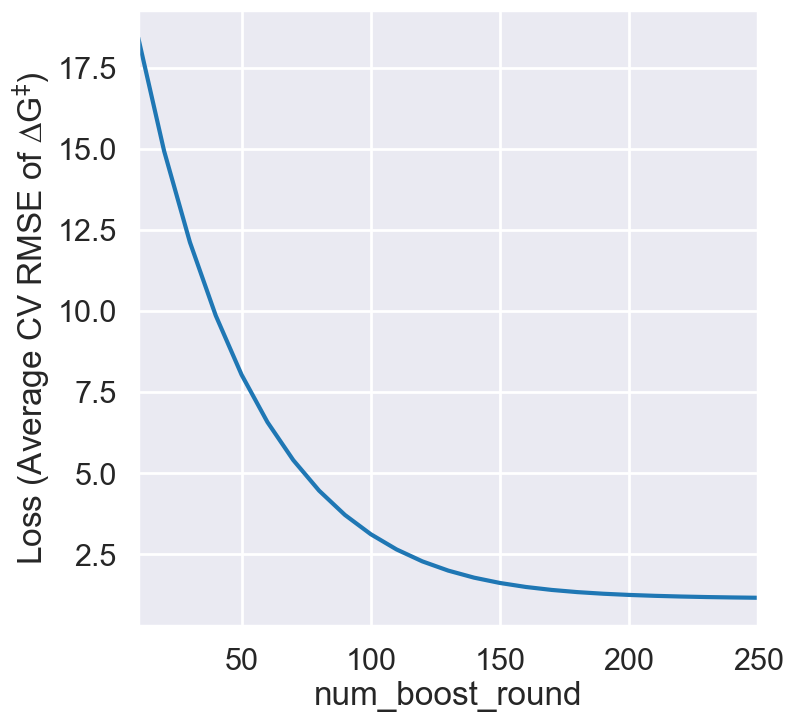

In [13]:
scan_n_trees(best_params)

From this plot, we observe that the cross-validation loss stops decreasing significantly near `num_boost_round = 185`. Increasing `num_boost_round` beyond this point decreases the average error by less than 0.1 kcal/mol, which is not chemically meaningful.

Thus, we can set `num_boost_round = 185` to avoid overfitting to the training data (and particularly to the catalysts present in the training data).

Below, we retrain the model on the entire training data set (`data_train`) using `num_boost_round = 185`.

In [14]:
xgb_final = xgboost.train(best_params, xgb_train, num_boost_round=185)

We now plot the results of this new model on Xin Hong's original training data (`data_train`).  The fit is no longer so completely perfect, which suggests that reducing the number of decision trees has reduced the amount of overfitting, and the overall performance is still excellent.

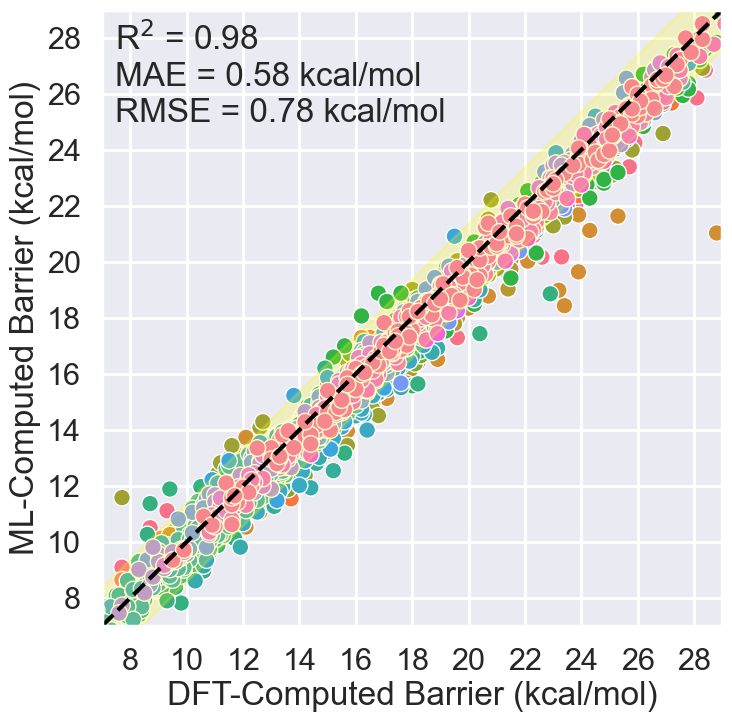

In [15]:
# Xin Hong Training Set
n_train, y_train_pred = test_with_reverse_reactions(x_train, xgb_final)
plot_results(y_train[:n_train], y_train_pred[:n_train],
             hue=rxns_train['cat_file'][:n_train])

We now plot the results of this new model on our two test sets.  First, we plot the results for Xin Hong's original test data (`data_hong`).  Again recall that every catalyst in Xin Hong's test data is also present in the training data; only the substrates are unseen.

Performance on this test set is almost identical to our previous overfit model, indicating that reducing the number of decision trees has not hindered the ability of the model to generalize to new substrates.

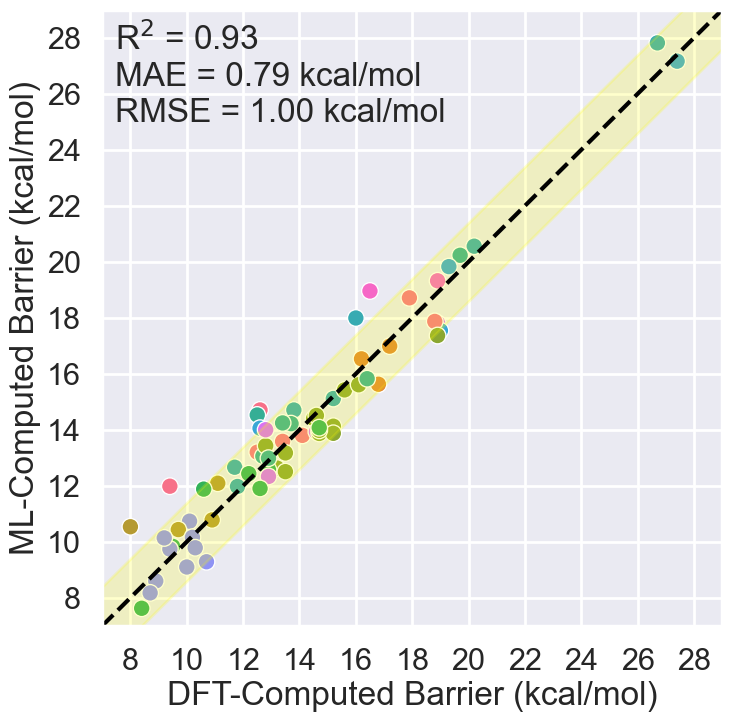

In [16]:
# Xin Hong Test Set
n_hong, y_hong_pred = test_with_reverse_reactions(x_hong, xgb_final)
plot_results(y_hong[:n_hong], y_hong_pred[:n_hong],
             hue=rxns_hong['cat_file'][:n_hong])

Second, we plot the results on the test data adapted from Kendall N. Houk (`data_houk`).  Recall that this data set, while small, contains three (out of four) catalysts that are not present in the training data (the t-BuO· catalyst is present in the training data).

Performance on this test set is substantially improved compared to the original overfit model: higher R^2, lower mean average error (MAE), and lower root mean square error (RMSE).  This confirms our hypothesis that reducing the number of decision trees has reduced overfitting and yielded a better model for generalizing to new and unseen catalysts.

The handle <matplotlib.collections.PathCollection object at 0x7f9492395700> has a label of '_nolegend_' which cannot be automatically added to the legend.


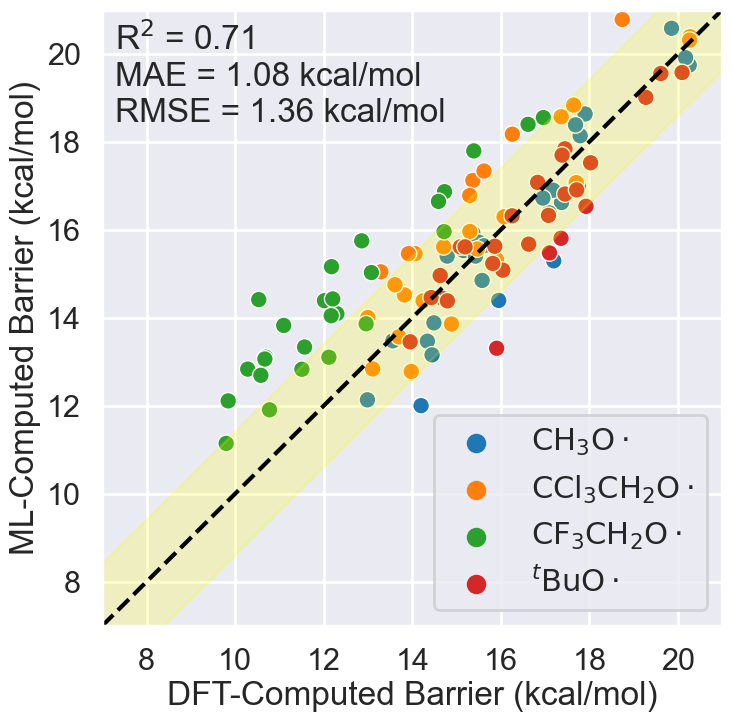

In [17]:
# Houk Test Set
n_houk, y_houk_pred = test_with_reverse_reactions(x_houk, xgb_final)
plot_results(y_houk[:n_houk], y_houk_pred[:n_houk], max_lim=21,
             hue=rxns_houk['cat_file'][:n_houk], hue_labels=labels_houk)

While this model performs much better on catalysts that are not present in the training data, there is still room for further improvement.

In particular, I am currently collecting additional training data on hydrogen atom transfer (HAT) reactions with more than 20 new catalysts.  The goal is to expand the number of catalysts on which the model is trained, and to construct validation sets which have no overlap in either substrates or catalysts with the training data.  This will enable the model validation process to avoid overfitting, rather than requiring a manual tuning of `num_boost_round` as this version of the model requires.

Thus, expanding the set of catalysts will lead to a more accurate next generation of this HATPredict model.

## 6. Model Introspection

Finally, we use [SHAP values](https://shap.readthedocs.io/en/latest/index.html) (SHapley Additive exPlanations), based on Shapley values, to investigate which features are most important in the final model for predicting the free energy barrier (∆G‡) of hydrogen atom transfer (HAT) reactions.

The bar graph below displays the mean absolute value of the SHAP value for the 20 most important input features, averaged over the entire training data set (`data_train`).  This value represents, on average, how much each feature changes the magnitude of ∆G‡ (in either direction) in kcal/mol.

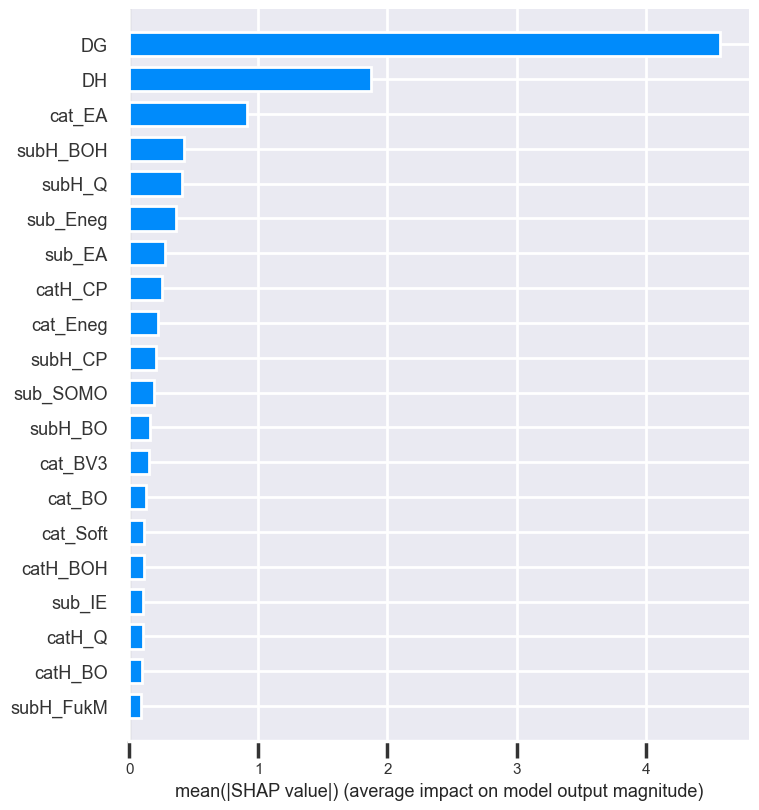

In [18]:
# Compute SHAP values using shap for the training data
explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(xgb_train)

# Plot the SHAP values for the top 20 input features averaged over each
# reaction in the training data
shap.summary_plot(shap_values, x_train, plot_type="bar")

Recall the hydrogen atom transfer (HAT) reaction between a substrate (**Sub–H**) and a catalyst (**Cat·**):

**Sub–H  +  Cat·  ⇌  Sub·  +  Cat–H**

The two most important features for predicting the free energy barrier for the reaction (∆G‡) are the overall free energy of reaction (∆G_rxn) and the overall enthalpy of reaction (∆H_rxn), consistent with [established studies](https://doi.org/10.1021/jacs.2c00389) of the Evans-Polanyi principle applied to hydrogen atom transfer (HAT) reactions.  Taken together, these two features (which are highly correlated) affect ∆G‡ by more than 6 kcal/mol.

Electronic features of the catalyst are next in importance, with the electron affinity of **Cat·** affecting ∆G‡ by nearly 1 kcal/mol on average. (Electronic features of the substrate are important too, since the fifth most important feature is the atomic charge present on the heavy atom of **Sub–H** which undergoes HAT.)  The importance of electronic features of the substrate and catalyst in controlling HAT free energy barriers is also [well-documented](https://doi.org/10.1021/jacs.2c00389).

Finally, the fourth most important feature is the average bond order in the substrate (**Sub–H**) between the heavy atom undergoing HAT and all hydrogens attached to it.  Not surprisingly, weaker bonds to hydrogen predict lower HAT free energy barriers.

Thus, the most important features in the final machine learning model, as quantified by SHAP values, are consistent with intuitive chemical explanations.

## 7. Save the Model

We conclude by saving the trained model as a `.json` file so that it can be used by the chemical community to predict the free energy barriers (∆G‡) of their own hydrogen atom transfer (HAT) reactions.  Please see `README.md` for instructions on using this model.

In [19]:
xgb_final.save_model('xgb_model.json')